In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, re

from astropy.table import Table, join, Column

from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
from thejoker import compute_likelihoods, likelihood

import astropy.units as u
import corner

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
ls ../results/

results_rvs.png     results_video.hdf5


In [3]:
fname = '../rvs.csv'
data = Table.read(fname)

In [4]:
t = data['JD']
rv = data['RV_wobble'] * u.m/u.s
err =  data['RV_err_wobble'] * u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)


Text(0, 0.5, 'RV [m/s]')

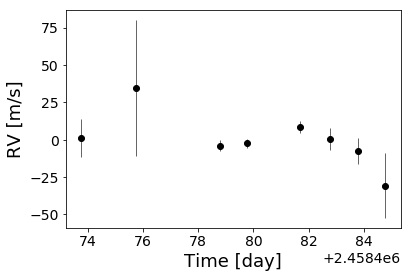

In [5]:
ax = data.plot() # doctest: +SKIP
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP


In [6]:
params = JokerParams(P_min=1*u.day, P_max=20*u.day)

In [7]:
joker = TheJoker(params)

In [11]:
%%time
samples = joker.rejection_sample(data, n_prior_samples=65536)

INFO: 6350 good samples after rejection sampling [thejoker.sampler.sampler]
CPU times: user 7.12 s, sys: 203 ms, total: 7.32 s
Wall time: 6.37 s


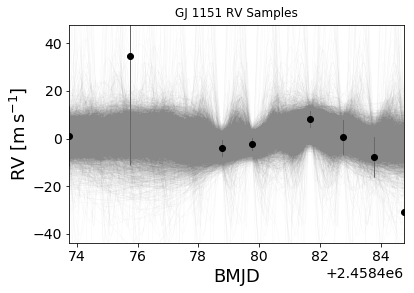

In [12]:
t_grid = np.linspace(t.min(), t.max(), 1024)

ax = data.plot() # doctest: +SKIP
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [km/s]") # doctest: +SKIP

plot_rv_curves(samples, t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
plt.savefig('gj1151b_samples.png',bbox_inches='tight')

In [14]:
test = samples.copy()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


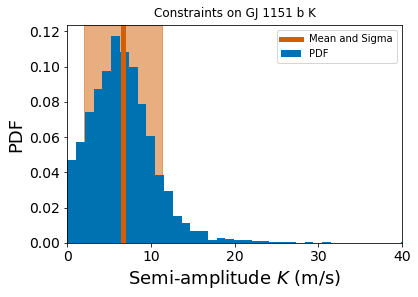

In [15]:
plt.xlim(0,40)
plt.axvline(test['K'].value.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(test['K'].value.mean()-test['K'].value.std(),test['K'].value.mean()+test['K'].value.std(),color=colours[2],alpha=0.5)
h = plt.hist(test['K'].value,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'Semi-amplitude $K$ (m/s)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b K',y=1.01)
plt.savefig('gj1151b_posterior.png',bbox_inches='tight')

### Now let's calculate the planet's mass

In [16]:
Ps = samples['P'].to(u.d).value

eccs = samples['e'].value

Ks = samples['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 


In [17]:
Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [18]:
print('Msini: %.2f +- %.2f' % (np.mean(Msini), np.std(Msini)),'M_Earth')

Msini: 5.15 +- 3.42 M_Earth


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


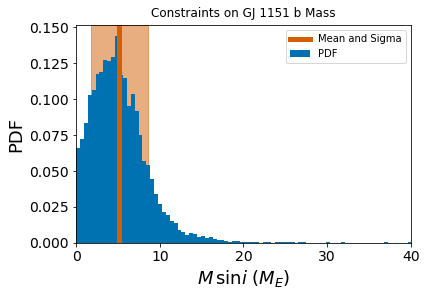

In [19]:
plt.xlim(0,40.)
plt.axvline(Msini.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(Msini.mean()-Msini.std(),Msini.mean()+Msini.std(),color=colours[2],alpha=0.5)
h = plt.hist(Msini,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'$M\, \sin{i}$ ($M_E$)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b Mass',y=1.01)
plt.savefig('gj1151b_mass.png',bbox_inches='tight')

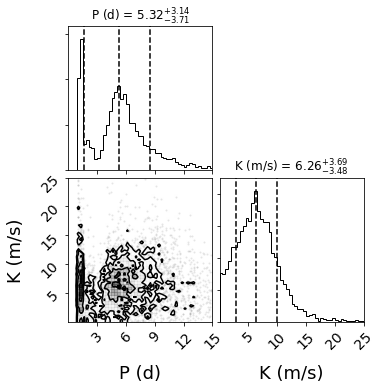

In [20]:
dummy = np.array([samples['P'].value,samples['K'].value]).T
corner.corner(dummy,labels=['P (d)','K (m/s)'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,15),(0,25)));
plt.savefig('cornerplot_k.png',bbox_inches='tight')